## DA HW 6

In [48]:
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

### Збір даних

In [49]:
penguins = sns.load_dataset('penguins')
penguins.head(7)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male
6,Adelie,Torgersen,38.9,17.8,181.0,3625.0,Female


### Попередня обробка даних:

#### Видалення записів з відсутніми значеннями

In [50]:
df = penguins.dropna()
print(f'\nBEFORE empty records:\n{penguins.isnull().sum()}') 
print(f'\nAFTER removal empty records:\n{df.isnull().sum()}')


BEFORE empty records:
species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

AFTER removal empty records:
species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64


#### Кодування категоріальних змінних (вид, острів, стать) за допомогою One-Hot Encoding.

In [51]:
enc = OneHotEncoder(sparse_output=False)
categorical_columns = df.select_dtypes(include=['object']).columns.to_numpy()
encoded = enc.fit_transform(df[categorical_columns])
encoded_columns = enc.get_feature_names_out()
encoded_columns_df = pd.DataFrame(data=encoded, columns=encoded_columns).drop('sex_Male', axis=1)
encoded_df = pd.concat([df.reset_index(drop=True), encoded_columns_df.reset_index(drop=True)], axis=1).drop(categorical_columns, axis=1)
encoded_df.tail(5)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,species_Adelie,species_Chinstrap,species_Gentoo,island_Biscoe,island_Dream,island_Torgersen,sex_Female
328,47.2,13.7,214.0,4925.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
329,46.8,14.3,215.0,4850.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
330,50.4,15.7,222.0,5750.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
331,45.2,14.8,212.0,5200.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
332,49.9,16.1,213.0,5400.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


### Розподіл даних:

#### Розділіть дані на тренувальний та тестовий набори (наприклад, в співвідношенні 80/20).

In [52]:
# Для моделі передбачення виду пінгвіна кодувати вид за допомогою OneHotEncoder не треба, тому закодуємо лише стать та острів
enc = OneHotEncoder(sparse_output=False)
categorical_columns = df[['sex', 'island']].columns.to_numpy()
encoded = enc.fit_transform(df[categorical_columns])
encoded_columns = enc.get_feature_names_out()
encoded_columns_df = pd.DataFrame(data=encoded, columns=encoded_columns).drop('sex_Male', axis=1)
data = pd.concat([df.reset_index(drop=True), encoded_columns_df.reset_index(drop=True)], axis=1).drop(categorical_columns, axis=1)

# Тепер розподілимо дані на вхідні та цільові:
target_col = 'species'
X = data.drop(columns=target_col) 
y = data[target_col]

# Тренувальний та тестовий набори (80/20):
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77)

### Створення pipeline:

In [9]:
pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('classifier', RandomForestClassifier(random_state=1))])

### Навчання та валідація моделі:

In [53]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=1))])

In [54]:
kf = KFold(n_splits=5, shuffle=True, random_state=10)
scores = cross_val_score(pipeline, X, y, cv=kf)

print(f'Оцінки кросс-валідації: {[f'{i:.3f}' for i in scores]}')
print(f'Середня оцінка:{scores.mean():.3f}')

Оцінки кросс-валідації: ['1.000', '1.000', '1.000', '0.970', '1.000']
Середня оцінка:0.994


### Тонка настройка:

In [55]:
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(pipeline, param_grid, n_jobs=-1, verbose=3, cv=5)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}


### Аналіз результатів:

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


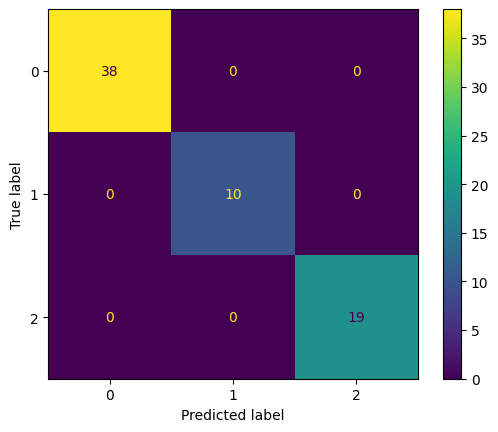

In [57]:
best_pipeline = grid_search.best_estimator_
y_pred = best_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')
               
conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
disp.plot()

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

####  Документація та висновки:

In [ ]:
# Для моделі передбачення пінгвінів були обрані наявні фізичні ознаки, острів та стать пінгвінів були перетворення у числовий вигляд.
# За допомогою GridSearchCV було з'ясовано, що для моделі "Випадковий ліс" найкращими параметрами буде використання 50 дерев, інші параметри (окрім заданого random_state) краще залиши за замовчуванням.
# Показники метрик (точність, повнота, Ф1) моделі 1.0 показує, що модель прораховує результати з найбільшою точністю на тестовій виборці.
# На матриці плутанини невірних результатів немає.
# В рамках вирішення задачі побудови учбової моделі, можна розраховувати, що модель вірно передбачить вид пінгвіну